Codes for making Figure 2a in the manuscript.

In [1]:
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(Signac))
suppressMessages(library(GenomicRanges))
suppressMessages(library(gridExtra))
suppressMessages(library(ggplot2))
suppressMessages(library(gridExtra))
suppressMessages(library(grid))

source('reproducibility_helper.R')

In [2]:
output_dir <- '/projects/chang/scGRN/analysis/real_data/output'
fig_dir <- '/projects/chang/scGRN/analysis/manuscript/figures'

In [3]:
datasets <- c('PBMC_10k_nextgem', 'PBMC_10k_nextgem_X', 'PBMC_10k')

res_list <- list()


fn_suffix <- c('', '', '_n_bootstrap_5000')
methods <- c('proposed', 'Signac', 'SCENT')
names(fn_suffix) <- methods

ct <- 'CD14 Mono'

In [4]:
p_cutoffs <- c(0.05,0.1,0.2)

rep_sum_list <- list()
#for(dpair in list(c(1,2),c(1,3))){
    res_list <- list()
    res_list[['proposed']] <- load_proposed(ct, datasets = datasets,
                                       fn_suffix = fn_suffix['proposed'],
                                           output_dir = output_dir) 
    res_list[['Signac']] <- load_Signac(ct, datasets = datasets,
                                       fn_suffix = fn_suffix['Signac'],
                                           output_dir = output_dir) 
    res_list[['SCENT']] <- load_SCENT(ct, 
                                  n_sets = 10,
                                  datasets = datasets,
                                  fn_suffix = fn_suffix['SCENT'],
                                           output_dir = output_dir) 

    sum_list <- list()
    for(nc in 1:length(p_cutoffs)){
        comb_list <- list(c(1,2), c(1,3))
        methods <- names(res_list)
        pval_vec <- fc_vec <- power_d1 <- power_d2 <- overlap_counts <- sig_counts_1 <- sig_counts_2 <- n_overlap <- numeric()
        fe_pval_vec <- fe_fc_vec <- fe_conf_l_vec <- fe_conf_u_vec <- numeric()
        results_list <- list()
        t <- 1
        for(i in 1:length(comb_list)){
            for(method in methods){
                tmp <- get_overlap(res_list[[method]][comb_list[[i]]],
                                   p_var = 'adj_pval', 
                                   p_cutoff = p_cutoffs[nc])
                pval_vec <- c(pval_vec, tmp$log_p_val)
                fc_vec <- c(fc_vec, tmp$fc)
                power_d1 <- c(power_d1, tmp$counts[[2]][1]/tmp$counts[[3]])
                power_d2 <- c(power_d2, tmp$counts[[2]][2]/tmp$counts[[3]])
                overlap_counts <- c(overlap_counts, tmp$counts[[1]])
                results_list[[t]] <- tmp

                # fisher exact test
                n_overlap_pairs <- results_list[[t]]$counts[[3]]
                n_sig_one_dataset <- results_list[[t]]$counts[[2]]
                n_sig_both <- results_list[[t]]$counts[[1]]

                D <- n_sig_both
                B <- n_sig_one_dataset[1] - D
                C <- n_sig_one_dataset[2] - D
                A <- n_overlap_pairs - (B + C + D)

                tab <- matrix(c(A,B,C,D), nrow = 2)
                fe_res <- fisher.test(tab, alternative = 'greater')

                fe_pval_vec <- c(fe_pval_vec, fe_res$p.value)
                fe_fc_vec <- c(fe_fc_vec, fe_res$estimate)
                fe_conf_l_vec <- c(fe_conf_l_vec, fe_res$conf.int[1])
                fe_conf_u_vec <- c(fe_conf_u_vec, fe_res$conf.int[2])

                sig_counts_1 <- c(sig_counts_1, n_sig_one_dataset[1])
                sig_counts_2 <- c(sig_counts_2, n_sig_one_dataset[2])
                n_overlap <- c(n_overlap, n_overlap_pairs)
                
                t <- t + 1
            }
        }
        sum_list[[nc]] <- data.frame(pval = -pval_vec, fc = fc_vec, power1 = power_d1, power2 = power_d2, repro_counts = overlap_counts,
                                    fe_pval = fe_pval_vec, fe_or = fe_fc_vec, fe_conf_l = fe_conf_l_vec, fe_conf_u = fe_conf_u_vec,
                                    sig_counts_1 = sig_counts_1, sig_counts_2 = sig_counts_2, n_overlap = n_overlap)
    }
    sum_df <- do.call(rbind, sum_list)
    sum_df$method <- rep(methods, 6)
    sum_df$p_cutoff <- rep(p_cutoffs, each = 6)
    sum_df$method <- factor(sum_df$method, levels = methods, labels = methods)
    sum_df$replicate <- rep(rep(c('technical', 'biological'), each = 3), 3)
    #rep_sum_list[[ifelse(all(dpair == 1:2), 'technical', 'biological')]] <- sum_df
#}

In [5]:
long_ct_sum_df <- sum_df
long_ct_sum_df$method <- factor(long_ct_sum_df$method,
                                levels = c('proposed', 'Signac', 'SCENT'),
                                labels = c('scMultiMap', 'Signac', 'SCENT'))
colnames(long_ct_sum_df)[colnames(long_ct_sum_df) == 'repro_counts'] <- 'counts1'

In [6]:
# saveRDS(long_ct_sum_df, sprintf('%s/manuscript/PBMC/reproducibility.rds', output_dir))

# Supplementary analysis for GBM

In [7]:
qu_cutoffs <- c(0.85,0.9,0.95)
    sum_list <- list()
    #for(nc in 1:length(p_cutoffs)){
    for(nc in 1:length(qu_cutoffs)){
        comb_list <- list(c(1,2), c(1,3))
        methods <- names(res_list)
        pval_vec <- fc_vec <- power_d1 <- power_d2 <- overlap_counts <- sig_counts_1 <- sig_counts_2 <- n_overlap <- numeric()
        fe_pval_vec <- fe_fc_vec <- fe_conf_l_vec <- fe_conf_u_vec <- numeric()
        results_list <- list()
        t <- 1
        for(i in 1:length(comb_list)){
           # for(method in methods){
            GBM_res <- load_GBM(ct, datasets = datasets[comb_list[[i]]], method_par = qu_cutoffs[nc],
                                output_dir = output_dir)
                tmp <- get_overlap(GBM_res,
                                   p_var='pval', p_cutoff=0.05)
                pval_vec <- c(pval_vec, tmp$log_p_val)
                fc_vec <- c(fc_vec, tmp$fc)
                power_d1 <- c(power_d1, tmp$counts[[2]][1]/tmp$counts[[3]])
                power_d2 <- c(power_d2, tmp$counts[[2]][2]/tmp$counts[[3]])
                overlap_counts <- c(overlap_counts, tmp$counts[[1]])
                results_list[[t]] <- tmp

                # fisher exact test
                n_overlap_pairs <- results_list[[t]]$counts[[3]]
                n_sig_one_dataset <- results_list[[t]]$counts[[2]]
                n_sig_both <- results_list[[t]]$counts[[1]]

                D <- n_sig_both
                B <- n_sig_one_dataset[1] - D
                C <- n_sig_one_dataset[2] - D
                A <- n_overlap_pairs - (B + C + D)

                tab <- matrix(c(A,B,C,D), nrow = 2)
                fe_res <- fisher.test(tab, alternative = 'greater')

                fe_pval_vec <- c(fe_pval_vec, fe_res$p.value)
                fe_fc_vec <- c(fe_fc_vec, fe_res$estimate)
                fe_conf_l_vec <- c(fe_conf_l_vec, fe_res$conf.int[1])
                fe_conf_u_vec <- c(fe_conf_u_vec, fe_res$conf.int[2])

                sig_counts_1 <- c(sig_counts_1, n_sig_one_dataset[1])
                sig_counts_2 <- c(sig_counts_2, n_sig_one_dataset[2])
                n_overlap <- c(n_overlap, n_overlap_pairs)
                
                t <- t + 1
            # }
        }
        sum_list[[nc]] <- data.frame(pval = -pval_vec, fc = fc_vec, power1 = power_d1, power2 = power_d2, repro_counts = overlap_counts,
                                    fe_pval = fe_pval_vec, fe_or = fe_fc_vec, fe_conf_l = fe_conf_l_vec, fe_conf_u = fe_conf_u_vec,
                                    sig_counts_1 = sig_counts_1, sig_counts_2 = sig_counts_2, n_overlap = n_overlap)
    }
    sum_df_GBM <- do.call(rbind, sum_list)
    sum_df_GBM$qu_cutoff <- rep(qu_cutoffs, each = 2)
    #sum_df$method <- factor(sum_df$method, levels = methods, labels = methods)
    sum_df_GBM$replicate <- rep(c('technical', 'biological'), 3)
    #rep_sum_list[[ifelse(all(dpair == 1:2), 'technical', 'biological')]] <- sum_df
#}

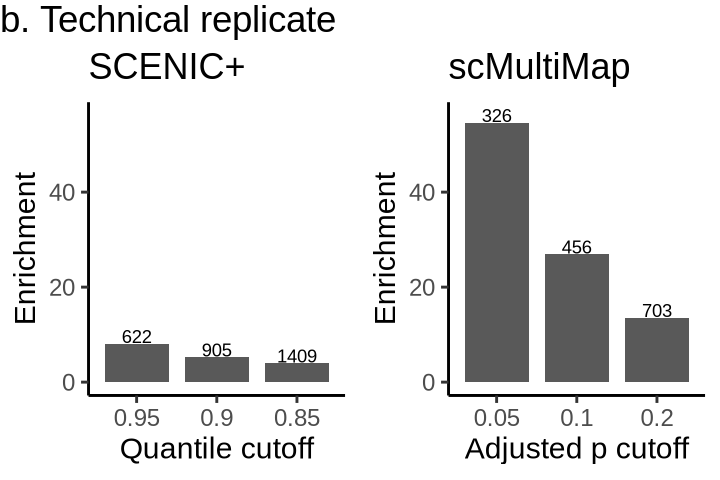

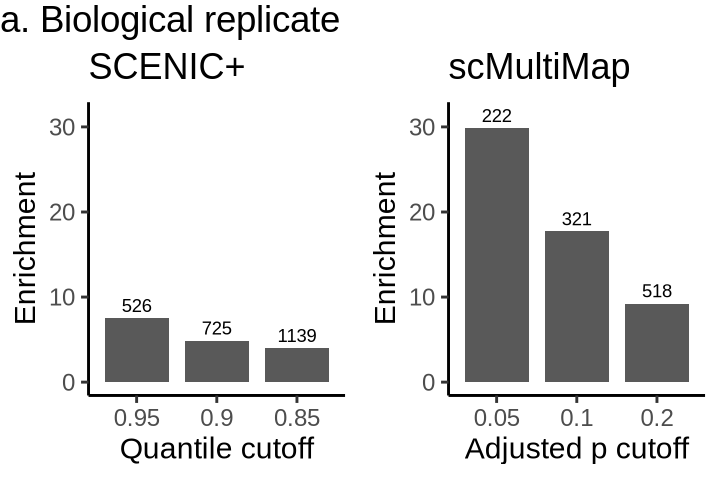

In [8]:
fig_letter <- c('b', 'a')
names(fig_letter) <- c('technical', 'biological')
for(replicate in c('technical', 'biological')){
    g_list <- list()

proposed_df <- long_ct_sum_df[long_ct_sum_df$replicate == replicate &
                              long_ct_sum_df$method == 'scMultiMap', c('fe_or', 'pval','p_cutoff', 'method', 'counts1')]
g_list[[2]] <- ggplot(proposed_df, 
                      aes( x = factor(p_cutoff), y = fe_or)) +
geom_bar(stat = 'identity', width = 0.8) +
geom_text(aes(label = counts1), nudge_y = 1.5) +
ylim(c(0, max(proposed_df$fe_or)+1.5)) +
labs(x = 'Adjusted p cutoff', y = 'Enrichment', title = 'scMultiMap') + 
theme_classic(base_size = 18) 

tmp <- sum_df_GBM[sum_df_GBM$replicate == replicate, c('fe_or', 'pval','qu_cutoff', 'repro_counts')]

g_list[[1]] <- ggplot(tmp, 
                      aes(x = factor(qu_cutoff, levels = c(0.95,0.9,0.85), labels = c(0.95,0.9,0.85)), y = fe_or)) +
geom_bar(stat = 'identity', width = 0.8) +
         geom_text(aes(label = repro_counts), nudge_y = 1.5) +
ylim(c(0, max(proposed_df$fe_or)+1.5)) +
labs(x = 'Quantile cutoff', y = 'Enrichment', title = 'SCENIC+') + 
theme_classic(base_size = 18) 



    options(repr.plot.width = 6, repr.plot.height = 4)
    g <- grid.arrange(grobs = g_list, nrow = 1, top = 
             textGrob(sprintf('%s. %s replicate', fig_letter[replicate],
                              paste(toupper(substr(replicate, 1, 1)), 
                                    substr(replicate, 2, nchar(replicate)), sep="")), 
                      gp=gpar(fontsize=22), x = 0, hjust = 0))
   # ggsave(sprintf('%s/PBMC/reproducibility_GBM_%s.pdf', fig_dir, replicate), g, width = 6, height = 4)
}